<a href="https://colab.research.google.com/github/qorganbek/ComputerVision-Spring-2024/blob/main/lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Finish training and validate on test data (print confusion matrix and report)

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import tqdm

In [84]:
import torch
import torchvision
from torchvision import transforms
from torchsummary import summary
import keras
from torch.utils.data import DataLoader, Dataset
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import load

In [85]:
import torch.nn as nn
import torch.nn.functional as F  # Functional

In [86]:
# dataset is available https://drive.google.com/drive/folders/1WJemKpDspMnvEU_4oyxkxAxgvVihuKr5?usp=sharing
#you can

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [87]:
path = '/content/drive/MyDrive/'

In [88]:
import os

In [89]:
directory = '/content/drive/MyDrive/NA_Fish_Dataset'
clases = os.listdir(directory)

In [90]:
clases

['Red Mullet',
 'Sea Bass',
 'Striped Red Mullet',
 'Shrimp',
 'Trout',
 'Black Sea Sprat',
 'Gilt Head Bream',
 'Horse Mackerel',
 'Red Sea Bream']

In [91]:
clases = clases[:3]

In [92]:
clases

['Red Mullet', 'Sea Bass', 'Striped Red Mullet']

In [93]:
directory = '/content/drive/MyDrive/NA_Fish_Dataset'
train_files = []
target_files = []
for fish_type in clases:
    for file in os.listdir(os.path.join(directory, fish_type)):
        train_files.append(os.path.join(directory, fish_type, file))
        target_files.append(fish_type)

In [94]:
df = pd.DataFrame({'img' : train_files, 'target' : target_files})
df.head()

,img,target
0,/content/drive/MyDrive/NA_Fish_Dataset/Red Mul...,Red Mullet
1,/content/drive/MyDrive/NA_Fish_Dataset/Red Mul...,Red Mullet
2,/content/drive/MyDrive/NA_Fish_Dataset/Red Mul...,Red Mullet
3,/content/drive/MyDrive/NA_Fish_Dataset/Red Mul...,Red Mullet
4,/content/drive/MyDrive/NA_Fish_Dataset/Red Mul...,Red Mullet


In [95]:
len(df)

150

In [96]:
img = []
for ind in tqdm.tqdm(range(len(df['img']))):
    origImage = cv2.imread(df['img'][ind])
    origImage = cv2.resize(origImage, (256, 256))
    img.append(origImage)
df['img'] = img

100%|██████████| 150/150 [00:09<00:00, 15.34it/s]


In [97]:
torch.cuda.is_available()

False

In [98]:
df.head()

,img,target
0,"[[[125, 101, 64], [125, 99, 73], [125, 103, 67...",Red Mullet
1,"[[[116, 95, 60], [119, 96, 67], [120, 95, 59],...",Red Mullet
2,"[[[133, 109, 54], [136, 115, 71], [134, 128, 8...",Red Mullet
3,"[[[132, 112, 65], [134, 123, 119], [137, 117, ...",Red Mullet
4,"[[[128, 104, 58], [125, 99, 65], [136, 117, 91...",Red Mullet


In [99]:
df['target'].unique()

array(['Red Mullet', 'Sea Bass', 'Striped Red Mullet'], dtype=object)

In [100]:
y = []
for i in range(len(df['target'])):
    for j in range(len(clases)):
        if df['target'][i] == clases[j]:
            y.append(j)

In [101]:
df.head()

,img,target
0,"[[[125, 101, 64], [125, 99, 73], [125, 103, 67...",Red Mullet
1,"[[[116, 95, 60], [119, 96, 67], [120, 95, 59],...",Red Mullet
2,"[[[133, 109, 54], [136, 115, 71], [134, 128, 8...",Red Mullet
3,"[[[132, 112, 65], [134, 123, 119], [137, 117, ...",Red Mullet
4,"[[[128, 104, 58], [125, 99, 65], [136, 117, 91...",Red Mullet


In [102]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(img, y, test_size=0.2, random_state=10)

In [103]:
len(y_train)

120

In [104]:
len(y_test)

30

In [105]:
import torch
import torchvision
from torchvision import transforms
from torchsummary import summary
from torch.utils.data import DataLoader,Dataset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

class MyDataset(Dataset):
    def __init__(self, data, targets,transform=None):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        if self.transform:
            x = Image.fromarray(self.data[index].astype(np.uint8))
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)
%matplotlib inline
transform = transforms.Compose([transforms.ToTensor()])
dataset = MyDataset(X_train,y_train, transform=transform)
trainloader = DataLoader(dataset, batch_size=4)

testset = MyDataset(X_test,y_test, transform=transform)
testloader = DataLoader(testset, batch_size=4)

In [106]:
class MyConvNet(nn.Module):
    def __init__(self):
        # вызов конструктора предка
        super(MyConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels= 6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(61 * 61 * 16, 120)  # !!!
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = x.view(-1, 16 * 61 * 61)  # !!!
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [107]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [108]:
if torch.cuda.is_available():
  net = MyConvNet().cuda()
else:
  net = MyConvNet()

batch = []



batch = next(iter(trainloader))
print(batch[0].shape)

#net.forward(torch.FloatTensor(batch[0]))

torch.Size([4, 3, 256, 256])


In [109]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [110]:
# conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
# pool = nn.MaxPool2d(kernel_size=2, stride=2)
# conv2 = nn.Conv2d(in_channels= 6, out_channels=16, kernel_size=5)
# x = conv1(batch[0])
# x = pool(x)
# x = conv2(x)
# x = pool(x)

# x.shape


In [111]:

loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
train_losses = []
test_losses = []
running_loss = 0
# итерируемся
for epoch in (range(10)):
    train_loss = []
    test_loss = []
    for i, batch in enumerate(trainloader):
        X_batch, y_batch = batch
        X_batch = X_batch.to(device=device, dtype=torch.float32)
        y_batch = y_batch.to(device = device, dtype = torch.long)
        optimizer.zero_grad()
        y_pred = net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        net.train(False)

    with torch.no_grad():
        for i, batch in enumerate(testloader):
            X_test_batch, y_pred_batch = batch
            X_test_batch = X_test_batch.to(device=device, dtype=torch.float32)
            y_pred_batch = y_pred_batch.to(device = device, dtype = torch.long)
            y_test_pred = net(X_test_batch)
            test_l = loss_fn(y_test_pred, y_pred_batch)
            test_loss.append(test_l.item())
    train_losses.append(np.mean(train_loss))
    test_losses.append(np.mean(test_loss))
    print('epoch ',epoch, ' train_loss ',np.mean(np.mean(train_loss)), ' test_loss ',np.mean(test_loss))


epoch  0  train_loss  1.939337690671285  test_loss  1.356166549026966
epoch  1  train_loss  1.2484446942806244  test_loss  1.0679518580436707
epoch  2  train_loss  1.0521900097529093  test_loss  0.9880601316690445
epoch  3  train_loss  0.9856899956862132  test_loss  0.9165279865264893
epoch  4  train_loss  0.9230075120925904  test_loss  0.8483529835939407
epoch  5  train_loss  0.8409842828909556  test_loss  0.7812945544719696
epoch  6  train_loss  0.7687703092892965  test_loss  0.722603801637888
epoch  7  train_loss  0.6933301856120427  test_loss  0.681320559233427
epoch  8  train_loss  0.6227623671293259  test_loss  0.6507001705467701
epoch  9  train_loss  0.5526256894071897  test_loss  0.6226792670786381


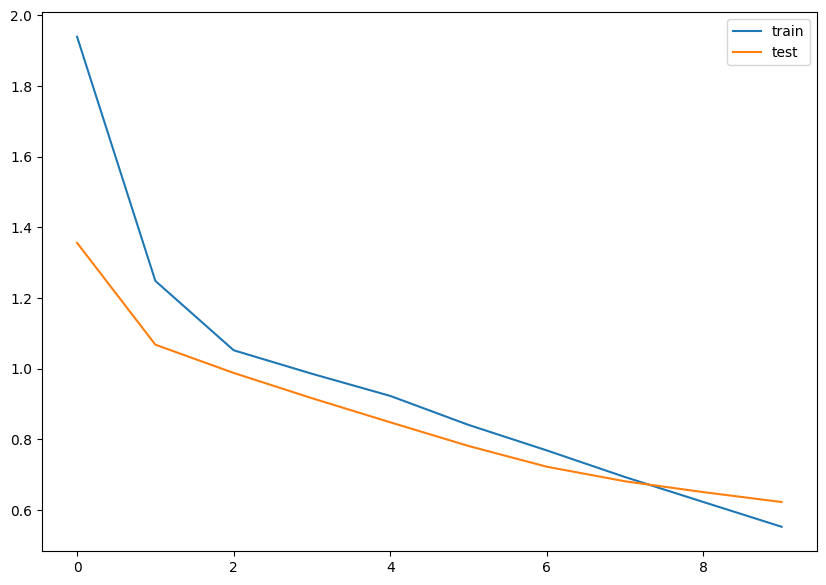

In [112]:
plt.figure(figsize=(10,7))
plt.plot(range(len(train_losses)), train_losses, label='train')
plt.plot(range(len(test_losses)), test_losses, label='test')
plt.legend()
plt.show()

In [113]:
y_pred = []
# Test your model on X_test data and show confusion_matrix and classification_report

In [114]:
from sklearn.metrics import confusion_matrix, classification_report

net.eval()

y_pred = []
y_true = []

with torch.no_grad():
  for inputs, labels in testloader:
    inputs, labels = inputs.to(device), labels.to(device)

    outputs = net(inputs)

    _, predicted = torch.max(outputs, 1)

    y_pred.extend(predicted.cpu().numpy())
    y_true.extend(labels.cpu().numpy())

y_pred = np.array(y_pred)
y_true = np.array(y_true)

conf_matrix = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:\n", conf_matrix)

class_report = classification_report(y_true, y_pred)
print("Classification Report:\n", class_report)

Confusion Matrix:
 [[ 7  2  1]
 [ 0 13  0]
 [ 1  3  3]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.72      1.00      0.84        13
           2       0.75      0.43      0.55         7

    accuracy                           0.77        30
   macro avg       0.78      0.71      0.72        30
weighted avg       0.78      0.77      0.75        30



In [115]:
y_pred[:5]

array([1, 2, 0, 1, 2])

In [116]:
# Add the block of code which will predict the value of one image

In [137]:
net.eval()
image_path = "/content/drive/MyDrive/NA_Fish_Dataset/Sea Bass/19.JPG"
image = Image.open(image_path).convert("RGB")
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

input_image = transform(image).unsqueeze(0)
input_image = input_image.to(device)
with torch.no_grad():
    output = net(input_image)

_, predicted_class = torch.max(output, 1)
print(clases)

print("Predicted class:", predicted_class.item())
probabilities = torch.nn.functional.softmax(output[0], dim=0)
max_prob, predicted_class = torch.max(probabilities, 0)

print("Predicted class:", predicted_class.item())
print("Max probability:", max_prob.item())

['Red Mullet', 'Sea Bass', 'Striped Red Mullet']
Predicted class: 0
Predicted class: 0
Max probability: 0.7691932320594788
